# **Introduction Générale**

Dans le cadre de l'UE Big Data, il nous est demandé de classifier des points de manière non supervisée en se basant sur différentes implémentations de K-Means.   
Au cours de ce travail, nous expliquerons l’implémentation, nous porterons une attention particulière à la parallélisation et à la gestion de la mémoire et nous étudierons les résultats obtenus pour chacune des implémentations.

# **Install and Load Libraries**

In [ ]:
!pip install apache-beam

In [ ]:
!pip install apache-beam[interactive]

In [ ]:
!pip install dask

In [ ]:
!python -m pip install 'fsspec>=0.3.3'

In [ ]:
import math
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time
import collections
import random

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from apache_beam.transforms.userstate import BagStateSpec
from bestAccuracy import *

import apache_beam as beam
from apache_beam import pvalue
from apache_beam import Create, FlatMap, Map, ParDo, Flatten, Partition
from apache_beam import Values, CoGroupByKey
from apache_beam import pvalue, window, WindowInto
from apache_beam.transforms import trigger
from apache_beam.runners.interactive.interactive_runner import InteractiveRunner
import apache_beam.runners.interactive.interactive_beam as ib
from dask import dataframe as df1
import sys

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# **Partie A.** Implémentation de k-means séquentiel 

## Fonctions utiles

In [ ]:
def timer(self, threshold):
    if (time.time() - self.lastTime) > threshold:
        self.lastTime = time.time()
        return True
    else:
        return False

In [ ]:
def read_csv(path):
  y=list()
  with open(path, 'r', newline='') as file:
    myreader = csv.reader(file, delimiter=',')
    for rows in myreader:
      y.append(rows)
  return np.array(y)

## Question 1 

Générer un jeu de données consistant en des points répartis en deux classes. On
pourra par exemple générer une première classe de 100 points répartis à
proximité d’un centroïde de coordonnées (5, 5) et une autre classe où 100 points
sont autour des coordonnées (10, 10). 

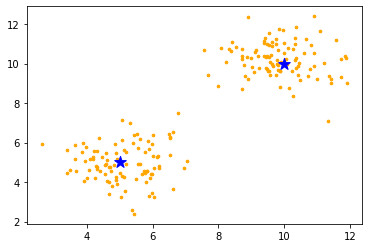

In [ ]:
center_1 = np.array([5,5])
center_2 = np.array([10,10])
centers=np.array([center_1,center_2])

cloud_1 = np.random.randn(100, 2) + center_1
cloud_2 = np.random.randn(100,2) + center_2

data = np.concatenate((cloud_1, cloud_2))

plt.scatter(data[:,0], data[:,1], s=7, c='orange')
plt.scatter(centers[:,0], centers[:,1], marker='*', c='blue', s=150)

Enregistrer ces données dans un fichier
(par exemple au format CSV).

In [ ]:
np.savetxt('data.csv', data, delimiter=',')

## Question 2

Afin de lire les données en consommant peu de mémoire nous pouvons:
*  ***Quantisation***:  
Changer le types des données en **float16** au lieu d'un **float64**.
*   ***Lire le fichier par segment***:   
Lire les données en morceaux de taille raisonnable: elles seront lues dans la mémoire et traitées avant de lire le morceau suivant. Pour ce faire nous utilisons la fonction *pandas.read_csv(chunksize)*, où le **chunksize** est la taille du bloc.  Cette fonction renvoie un itérateur qui est utilisé pour parcourir ces morceaux, puis elle les traite. Comme seule une partie du fichier est lue à la fois, une *faible mémoire suffit pour le traitement*.
*   ***Paralléliser les calculs***:   
Et ce en utilisant la bibliothèque open source **Dask** qui utilise plusieurs cœurs de processeur ou clusters de machines (calculs distribués).




Commençons par générer un grand nombre de données

In [ ]:
cloud_1 = np.random.randn(10000000, 2)+center_1
cloud_2 = np.random.randn(10000000,2)+center_2

df = np.concatenate((cloud_1, cloud_2))

In [ ]:
np.savetxt('bigdata.csv', df, delimiter=',')

Maintenant, appliquons les différentes méthodes et analysons les resultats.

In [ ]:
s_time = time.time()
f= open (r"bigdata.csv")
myReader = csv.reader(f)
e_time = time.time()
print("La lecture avec csv reader prend: ", (e_time-s_time), "secondes et consomme: ", sys.getsizeof(myReader) ," octets")  

s_time = time.time()
myReader = read_csv("bigdata.csv")
e_time = time.time()
print("La lecture avec csv reader et sauvegarde des données prend: ", (e_time-s_time), "secondes et consomme: ", sys.getsizeof(myReader) ," octets")  

s_time = time.time()
df = pd.read_csv("bigdata.csv", header=None)
e_time = time.time()
print("La lecture avec pandas prend: ", (e_time-s_time), "secondes et consomme: ", sys.getsizeof(df) ," octets") 

s_time = time.time()
df = pd.read_csv("bigdata.csv", header=None, dtype="float16")
e_time = time.time()
print("La lecture avec pandas en chengeant le type prend: ", (e_time-s_time), "secondes et consomme: ", sys.getsizeof(df) ," octets")  

s_time_chunk = time.time()
chunk = pd.read_csv('bigdata.csv', chunksize=1000, header=None)
e_time_chunk = time.time()
print("La lecture avec les chunks prend: ", (e_time_chunk-s_time_chunk), "secondes et consomme: ", sys.getsizeof(chunk) ," octets") 

s_time_dask = time.time()
df = df1.read_csv('bigdata.csv', header=None)
e_time_dask = time.time()
print("La lecture avec Dask prend: ", (e_time_dask-s_time_dask), "secondes et consomme: ", sys.getsizeof(df) ," octets") 


La lecture avec csv reader prend:  0.0002942085266113281 secondes et consomme:  120  octets
La lecture avec csv reader et sauvegarde des données prend:  64.34714865684509 secondes et consomme:  4000000120  octets
La lecture avec pandas prend:  9.466624975204468 secondes et consomme:  320000160  octets
La lecture avec pandas en chengeant le type prend:  8.443256855010986 secondes et consomme:  80000160  octets
La lecture avec les chunks prend:  0.003287076950073242 secondes et consomme:  64  octets
La lecture avec Dask prend:  0.03243541717529297 secondes et consomme:  64  octets


**Remarques:** 
- Comme les bibliothéques *Pandas* et *Dask* peuvent faire appel à plusieurs 
fonctions, nous avons jugé plus équitable de les comparer avec le *csv.reader* après qu'il ait stocké les données dans une liste: nous avons choisi de les stocker dans une numpy array car elle consomme moins de mémoire que la liste tarditionnelle.  
- Ainsi, le temps d'execution et la mémoire utilisée augmentent pour le *csv_reader*.  
- Les données float16 utilisent quatre fois moins de mémoire que le float64. Cependant, le float16 ne garde que deux chiffres après la virgule, et nos données contiennent 16 chiffres après la virgule.   
Nous perdons donc de l'information avec cette méthode.
- Dans la littérature, sur de grands datasets avec plusieurs colonnes, Dask surpasse Pandas avec Chunk car il parallélise les calculs.   
Notre jeu de données actuel démontre parfaitement qu'il n'est pas forcément nécéssaire de compliquer les choses, et que des méthodes plus traditionnelles avec de bons paramétrages peuvent largement faire l'affaire.

**Conclusion:** 
- Lire les données par segment via les chunks et paralléliser les calucls via Dask sont les deux méthodes de lecture qui consomment le moins de mémoire. 

## Question 3

Afin d'implément l’algorithme k-means séquentiel nous suivons le pseudo algorithme suivant:  
a. Choix aléatoire de k centres μ1, ..., μ𝑘. 
b. Pour chaque nouveau point  𝑥𝑖: 
- Calculer le centre μ𝑗 le plus proche de 𝑥𝑖. On note 𝑛𝑗 l’effectif de la classe associée.
- ii. Mettre à jour le centre μ𝑗 et l’effectif 𝑛𝑗:  
 - μ𝑗 ← μ𝑗 + (1/(𝑛𝑗+1)) * (𝑥𝑖−μ𝑗)  
 - 𝑛𝑗 ← 𝑛𝑗 + 1

In [ ]:
def my_seq_kmeans(data,nb_cluster):

               ############################
               # fonctions intermediaires #
              ############################

  def init_kmeans(data, nb_cluster): 
      #Initialiser les centroides
      idx = np.random.randint(low=0, high = len(data), size=2, dtype='int16')
      init= np.array( [data[idx[i]] for i in range(len(idx))])
      #Initialiser le nombre d'effectifs des classes  
      effectif= np.repeat(0, nb_cluster)
      return init, effectif  

  def calculate_distance(centers, x):
    return np.argmin([np.linalg.norm(x-i) for i in centers])

  
  def calculate_parameters(centre,effectif,x):
    centre += (1/(effectif+1))*(x- centre)
    effectif += 1
    return centre, effectif

               ####################
               # Implementation  #
              ####################
            
  # Initialisations du timer, des centres, des effectifs et des clusters pour chaque point
  start_time = time.time()
  centroids, effectif=init_kmeans(data, nb_cluster)
  classe = np.repeat(np.nan, len(data)).astype('int8')

  for i, x in enumerate(data):
    # Recherche du plus proche centroid 
    u = calculate_distance(centroids,x)
    # Mise à jour des parametres
    centroids[u], effectif[u]= calculate_parameters(centroids[u], effectif[u], x)
    classe[i]= u  
  
  exec_time= ((time.time() - start_time))
  
  return classe, centroids, exec_time

**Remarque:** Pour optimiser la mémoire consommée lors de notre implementation, nous avons utilisé des numpy array au lieu des listes.



## Question 4

In [ ]:
result=my_seq_kmeans(data, 2)[0]
array = bytearray(result)

print("Si les résultats de l'algorithme sont en 'liste', ils occuperont: ", sys.getsizeof(result.tolist()), " octets")
print("Si les résultats de l'algorithme sont en 'numpy array', ils occuperont: ", sys.getsizeof(result), " octets")
print("Si les résultats de l'algorithme sont en 'binaire', ils occuperont: ", sys.getsizeof(array), " octets")



Si les résultats de l'algorithme sont en 'liste', ils occuperont:  1672  octets
Si les résultats de l'algorithme sont en 'numpy array', ils occuperont:  304  octets
Si les résultats de l'algorithme sont en 'binaire', ils occuperont:  257  octets


Afin d'enregistrer les résultats de l’algorithme dans un fichier de manière à consommer peu de mémoire nous avons choisi de les sauvegarder au format **binaire**.

In [ ]:
resultFile = open("result.bin", "wb")
resultByteArray = bytearray(result)
resultFile.write(resultByteArray)

200

## Question 5

Afin de valider la cohérence des résultats obtenus avec notre implémentation du kmeans sequentiel, nous allons visualiser et utiliser des mesures d’évaluation adaptées.

In [ ]:
result=my_seq_kmeans(data, 2)
pred_labels=result[0]
centers=np.array(result[1])
exec_time=result[2]

labels = KMeans(n_clusters=2, random_state=0).fit(data).labels_

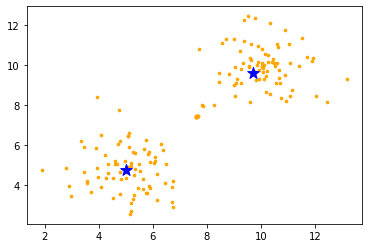

In [ ]:
plt.scatter(data[:,0], data[:,1], s=7, c='orange')
plt.scatter(centers[:,0], centers[:,1], marker='*', c='blue', s=150)

In [ ]:
print(" ********************* \n * Résultats obtenus * \n *********************")
print('ARI = ', adjusted_rand_score(labels,pred_labels)) 
print('Nmi = ', normalized_mutual_info_score(labels,pred_labels)) 
print('Accuracy = ', bestAccuracy(labels,pred_labels)) 
print('Temps d\'execution = % secondes ' % exec_time) 

 ********************* 
 * Résultats obtenus * 
 *********************
ARI =  0.9799999971717882
Nmi =  0.9594581645786119
Accuracy =  0.995
Temps d'execution = 0.006746768951416016econdes 


# **Partie B.** Implémentation d’une version streaming de k-means

L’implémentation séquentielle de k-means souffre d’un inconvénient : si la distribution
des données change au cours du temps (concept drift), les centres se déplacent et
l’affectation aux clusters n’est alors plus toujours cohérente. Reboucler sur les données
permet d’atténuer cet effet. Dans cette partie, une autre solution est proposée. Elle
permet de s’affranchir de reboucler sur toutes les données en conservant en mémoire
un sous-ensemble des données : les dernières arrivées.

Implémenter l’algorithme suivant :

**Hyper-paramètres** : Soit T le nombre maximum de batches à garder en mémoire, et un
paramètre r qui contrôle le poids à accorder à l’historique (plus il est grand, moins les
anciens batches pèseront dans la contribution aux centres).

**Entrées** : X l’ensemble des batches précédents partitionnés par P (aléatoire si il n’y a pas
de batch précédent), et B⁰ le nouveau batch.

**Algorithme** :
- Si la taille de X est T : enlever le plus vieux batch de X
- Ajouter B⁰ à X
- Initialiser les centroïdes C avec la partition P
- Obtenir les centroïdes C et la partition P avec l’algorithme k-means pondéré :
- les points des batches sont pondérés par rt où t est le numéro du batch
ordonné par ordre décroissant : 0 est le batch le plus récent, 1 est le batch
précédent, etc.
- utiliser l’argument sample_weight de la méthode fit de
l’implémentation k-means de scikit-learn :
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.
html#sklearn.cluster.KMeans.fit

**Sortie** : l’ensemble des centroïdes C et la partition associée P.

In [ ]:
# calculer le poids pour les points de chaque batch
def compute_weight_batch(X):
  w = []
  for idx, batche in enumerate(X):
    for point in batche:
      w.append(r**idx)
  return w

In [ ]:
# streaming kmeans
# sortie : les centroides et la partition
def streaming_k_means(X, P, B, Ci):

  # Si la taille de X est T 
  # enlever le plus vieux batch de X
  # retirer les labels des points appartenant au plus vieux batch de X
  if len(X) == T :
    a = X.pop(0)

  # Ajouter B⁰ à X  
  X.append(B)

  # Initialiser les centroïdes C avec la partition P
  n_clusters = len(set(P))
  init = Ci

  # Obtenir les centroïdes C et la partition P avec l’algorithme k-means pondéré
  kmeans = KMeans(n_clusters=n_clusters, init=init, random_state=0).fit(np.concatenate(X), y=None, sample_weight=compute_weight_batch(X))
  C = kmeans.cluster_centers_
  P = kmeans.labels_
  
  return C,P 

In [ ]:
# Hyper-paramètres : 
## Soit T le nombre maximum de batches à garder en mémoire, à utiliser durant k-means
T = 3

## Soit r un paramètre qui contrôle le poids à accorder à l’historique (plus il est grand, moins les anciens batches pèseront dans la contribution aux centres)
r = 5


# Entrées : 
## X l’ensemble des batches précédents partitionnés par P (aléatoire si il n’y a pas de batch précédent)
X = []

## tous les batches
Batches = [
           ((0,0), (1,1), (10,10)),
           ((5,17), (2,7)),
           ((3,4), (10,4)),
           ((22,5), (12,9)),
           ((16,1), (1,6))
           ]

## Partition de départ aléatoire
P = [(k%2) for k in range(len(Batches[0]))]

# Centroides de départ aléatoire
Ci = np.array([Batches[0][0], Batches[0][1]], dtype=object)

In [ ]:
print(f'Le nombre maximum de batches à garder en mémoire est : {T}')
print(f'Le poids à accorder à l’historique est : {r}')

# début du temps d'exécution de l'algorithme 
start = time.time()

# idx le n° du batch
# B le nouveau batch 
for idx, B in enumerate(Batches):
  
  C,P = streaming_k_means(X, P, B, Ci)
  Ci = C

  print(f'\nBatche n°{idx}')
  print(f'Les centres sont : {C}')
  print(f'La partition est : {P}')

# Fin du temps d'exécution de l'algorithme
end = time.time()
 
print(f'\nLe temps de exécution du programme est : {end-start}')

Le nombre maximum de batches à garder en mémoire est : 3
Le poids à accorder à l’historique est : 5

Batche n°0
Les centres sont : [[ 0.5  0.5]
 [10.  10. ]]
La partition est : [0 0 1]

Batche n°1
Les centres sont : [[ 1.57142857  5.14285714]
 [ 5.83333333 15.83333333]]
La partition est : [0 0 1 1 0]

Batche n°2
Les centres sont : [[ 5.96551724  4.24137931]
 [ 5.         17.        ]]
La partition est : [0 0 0 1 0 0 0]

Batche n°3
Les centres sont : [[16.36363636  6.72727273]
 [ 3.14285714  6.28571429]]
La partition est : [1 1 1 0 0 0]

Batche n°4
Les centres sont : [[16.11111111  2.75      ]
 [ 1.07692308  5.92307692]]
La partition est : [1 0 0 0 0 1]

Le temps de exécution du programme est : 0.0284578800201416


# **Partie C.** Implémentation de k-means distribué 

## Fonction Utile



In [ ]:
# Calcule de la moyenne pour un tuple.
# Return un tuple avec la moyen pour le tuple[0] et le tuple[1]

def avg(list):
    return sum(list)/len(list)

def my_mean_tuple(element):
    clust = element[0]
    mean = element[1]
    return (clust,tuple(map(avg, zip(*mean))))

## Création des données comme pour la partie A

In [ ]:
# Création de la liste data1 comportant les points proche du centre (5,5)
data1 = np.random.normal(loc=5, scale=2, size=(100, 2))

# Création de la liste data2 comportant les points proche du centre (10,10)
data2 = np.random.normal(loc=10, scale=2, size=(100, 2))

# Concatenation des deux listes
X = np.concatenate([data1, data2])

# Création d'une liste de tuple
all_data = [tuple(x) for x in X]

# On melange la nouvelle liste
random.shuffle(all_data)

## Question 1

Créer une PCollection qui contient l’ensemble des points.

In [ ]:
with beam.Pipeline() as pipeline:
  data = (
      pipeline
      # Création de la Pcollection
      | 'Create coordinates' >> beam.Create(all_data)
                                                                        
  )
  data | beam.Map(print)

(11.063504725182785, 9.974646165297097)
(8.957940174417772, 7.964581246254616)
(8.85681559290358, 12.323130662479954)
(9.372970631185185, 9.645274499644213)
(7.652486015864871, 10.935063968313464)
(4.40083143750295, 4.594702532461235)
(3.917072163921773, 4.752879002331477)
(7.2625667940859415, 11.46425397934662)
(6.905035089245011, 3.151161348886533)
(3.674888148484052, 4.329780711482489)
(11.403303858640264, 9.125393884770414)
(2.463963776258666, 5.788989201985596)
(9.45097479919355, 6.593646282119616)
(3.847760038759189, 5.931775697922022)
(-0.8572087951704424, 5.346064184896565)
(3.0190511374176756, 5.0880410706286145)
(6.851863790655598, 9.890593533494116)
(12.252113120831766, 7.652285320074872)
(9.371785659762786, 11.562141509420117)
(3.778637300094286, 7.057120736643427)
(12.757877698862696, 9.740588616338343)
(4.604083473934976, 4.966488507500787)
(9.13993721964989, 10.388786405184376)
(5.291469924915107, 7.601629783233187)
(9.135479393061885, 8.185144867627741)
(4.7878155637326

## Question 2

Pour l’initialisation, transformer la PCollection précédente pour que chaque
élément de la nouvelle PCollection soit un tuple où :  
a. le premier élément est le numéro de cluster choisi aléatoirement ;  
b. le second élément du tuple soit les coordonnées du point.

In [ ]:
with beam.Pipeline() as pipeline:
  data = (
      pipeline
      # Création de la Pcollection
      | 'Create list with all elements in 2 dimension' >> beam.Create(all_data)
      # Affectation des clusters aléatoire aux coordonnées
      | 'Add random cluster' >> beam.Map(lambda x: (random.randint(0,1),(x[0],x[1])))
  )
  data | beam.Map(print)

(1, (11.063504725182785, 9.974646165297097))
(1, (8.957940174417772, 7.964581246254616))
(0, (8.85681559290358, 12.323130662479954))
(1, (9.372970631185185, 9.645274499644213))
(0, (7.652486015864871, 10.935063968313464))
(0, (4.40083143750295, 4.594702532461235))
(1, (3.917072163921773, 4.752879002331477))
(1, (7.2625667940859415, 11.46425397934662))
(1, (6.905035089245011, 3.151161348886533))
(0, (3.674888148484052, 4.329780711482489))
(1, (11.403303858640264, 9.125393884770414))
(1, (2.463963776258666, 5.788989201985596))
(0, (9.45097479919355, 6.593646282119616))
(0, (3.847760038759189, 5.931775697922022))
(0, (-0.8572087951704424, 5.346064184896565))
(1, (3.0190511374176756, 5.0880410706286145))
(1, (6.851863790655598, 9.890593533494116))
(0, (12.252113120831766, 7.652285320074872))
(0, (9.371785659762786, 11.562141509420117))
(1, (3.778637300094286, 7.057120736643427))
(0, (12.757877698862696, 9.740588616338343))
(0, (4.604083473934976, 4.966488507500787))
(1, (9.13993721964989, 

## Question 3

Implémenter l’étape de calcul des centres : Une PCollection nommée
centroids sera créée pour ça.   
Chaque élément sera un tuple (numéro de
cluster, coordonnées du centroïde).

In [ ]:
with beam.Pipeline() as pipeline:
  centroids = (
      pipeline
      # Création de la Pcollection
      | 'Create list with all elements in 2 dimension' >> beam.Create(all_data)
      # Affectation des clusters aléatoire aux coordonnées
      | 'Add random cluster' >> beam.Map(lambda x: (random.randint(0,1),(x[0],x[1])))
      # On regroupe les tuples par cluster
      | 'Group by cluster id' >> beam.GroupByKey()
      # On calcule les centroides des clusters avec notre fonction my_mean_tuple 
      | 'Calculate cluster mean' >> beam.Map(my_mean_tuple)
  )
  centroids | beam.Map(print)

(0, (7.905746023001732, 7.893159265250543))
(1, (7.260375052092359, 7.240612354058929))


## Question 4 - A

Créer une fonction assign_cluster qui prend deux entrées :  
i. un point (ses coordonnées).  
ii. un dictionnaire de centroïdes où la clé correspond au numéro de
cluster et la valeur correspond aux coordonnées du centroïde.  
La fonction retourne un tuple avec :  
- le numéro du cluster le plus proche du point ;  
- les coordonnées du point.  

Formule pour calculer la distance euclidienne

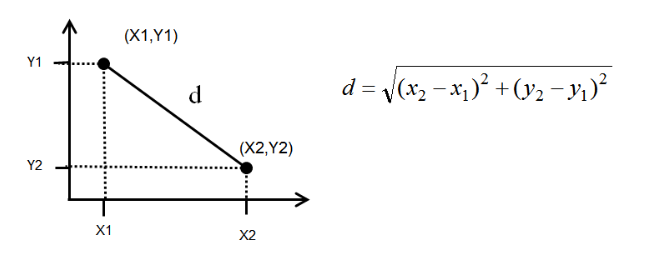

In [ ]:
def assign_cluster(coordinate, centroid_dic):
  # On commence par la première clef du dictionnaire 
  cluster = list(centroid_dic.keys())[0]

  # On calcule la distance euclidienne du premier centroide du dictionnaire avec le point coordinate. 
  # Cette étape nous permet d'avoir une distance de référence qui va nous servir pour trouver le cluster le plus proche pour le point coordinate
  distance = np.sqrt((coordinate[0]-list(centroid_dic.values())[0][0])**2+(coordinate[1]-list(centroid_dic.values())[0][1])**2)
  for clusters,centers in centroid_dic.items():
    # On regarde si notre distance actuelle est minimale, si elle ne l'est pas, on met à jour le cluster et la distance

    if distance > np.sqrt((coordinate[0]-centers[0])**2+(coordinate[1]-centers[1])**2):
      cluster = clusters
      distance = np.sqrt((coordinate[0]-centers[0])**2+(coordinate[1]-centers[1])**2)

  # On retourne le cluster avec la distance minimale entre le point coordinate et le centroide le plus proche
  return (cluster,coordinate)

## Question 4 - B

b. Assigner à chaque point son numéro de cluster :  
i. Utiliser la méthode Map avec les centroïdes comme entrée
complémentaire sous forme de dictionnaire.  


In [ ]:
with beam.Pipeline() as pipeline:
  centroid_dic = (
      pipeline
      # Création de la Pcollection
      | 'Create list with all elements in 2 dimension' >> beam.Create(all_data)
      # Affectation des clusters aléatoire aux coordonnées
      | 'Add random cluster' >> beam.Map(lambda x: (random.randint(0,1),(x[0],x[1])))
      # On regroupe les tuples par cluster
      | 'Group by cluster id' >> beam.GroupByKey()
      # On calcule les centroides des clusters avec notre fonction my_mean_tuple 
      | 'Calculate cluster mean' >> beam.Map(my_mean_tuple)
  )  
  data = (
      pipeline
      # Creation de 100 tuples avec des coordonées aléatoire (entre 0 et 100)
      | 'Create random points in 2 dimension' >> beam.Create(all_data)
      | 'Affect centroid' >> beam.Map(
          assign_cluster,
          centroid_dic=beam.pvalue.AsDict(centroid_dic),
      )
      | beam.Map(print))

(0, (11.063504725182785, 9.974646165297097))
(0, (8.957940174417772, 7.964581246254616))
(0, (8.85681559290358, 12.323130662479954))
(0, (9.372970631185185, 9.645274499644213))
(0, (7.652486015864871, 10.935063968313464))
(1, (4.40083143750295, 4.594702532461235))
(1, (3.917072163921773, 4.752879002331477))
(0, (7.2625667940859415, 11.46425397934662))
(1, (6.905035089245011, 3.151161348886533))
(1, (3.674888148484052, 4.329780711482489))
(0, (11.403303858640264, 9.125393884770414))
(1, (2.463963776258666, 5.788989201985596))
(0, (9.45097479919355, 6.593646282119616))
(1, (3.847760038759189, 5.931775697922022))
(1, (-0.8572087951704424, 5.346064184896565))
(1, (3.0190511374176756, 5.0880410706286145))
(0, (6.851863790655598, 9.890593533494116))
(0, (12.252113120831766, 7.652285320074872))
(0, (9.371785659762786, 11.562141509420117))
(1, (3.778637300094286, 7.057120736643427))
(0, (12.757877698862696, 9.740588616338343))
(1, (4.604083473934976, 4.966488507500787))
(0, (9.13993721964989, 

ii. Quelle supposition fait-on pour passer les centroïdes sous cette
forme ? Peut-on optimiser cette étape ? Si oui, modifier
l’implémentation de l’étape de partitionnement pour pallier ça.

Dans la documentation on peut lire que l'utilisation d'un *side inputs as dictionaries* permet : 

***Note that all the elements of the PCollection must fit into memory for this.*** 

On suppose donc que les centroïdes sous cette forme sont chargable en mémoire.

Deplus, nous pouvons lire aussi que l'utilisation d'un *side inputs as iterators* permet de :

 ***...It is possible to iterate over large PCollections that won’t fit into memory.***

L'utilisation d'un side inputs as iterators permet d'optimiser la mémoire. Nous changons la fonction précédente afin de faire d'utiliser un iterator

Nous modifions donc le code pour pallier à cela

In [ ]:
def assign_cluster(coordinate, centroid_list):
  # On initialise la distance distance a infini pour pourvoir la mettre à jour.
   
  distance = float('inf')
  for clusters,centers in centroid_list:
    # On regarde si notre distance actuelle est minimale, si elle ne l'est pas, on met à jour le cluster et la distance

    if distance > np.sqrt((coordinate[0]-centers[0])**2+(coordinate[1]-centers[1])**2):
      cluster = clusters
      distance = np.sqrt((coordinate[0]-centers[0])**2+(coordinate[1]-centers[1])**2)

  # On retourne le cluster avec la distance minimale entre le point coordinate et le centroide le plus proche
  return (cluster,coordinate)

In [ ]:
with beam.Pipeline() as pipeline:
  centroid_list = (
      pipeline
      # Création de la Pcollection
      | 'Create list with all elements in 2 dimension' >> beam.Create(all_data)
      # Affectation des clusters aléatoire aux coordonnées
      | 'Add random cluster' >> beam.Map(lambda x: (random.randint(0,1),(x[0],x[1])))
      # On regroupe les tuples par cluster
      | 'Group by cluster id' >> beam.GroupByKey()
      # On calcule les centroides des clusters avec notre fonction my_mean_tuple 
      | 'Calculate cluster mean' >> beam.Map(my_mean_tuple)
  )  
  data = (
      pipeline
      # Creation de 100 tuples avec des coordonées aléatoire (entre 0 et 100)
      | 'Create random points in 2 dimension' >> beam.Create(all_data)
      | 'Affect centroid' >> beam.Map(
          assign_cluster,
          centroid_list=beam.pvalue.AsIter(centroid_list), #ne charge rien en mémoire
      )
      | beam.Map(print))

# **Partie D.** Implémentation de k-means séquentiel distribuée

In [ ]:
##############
# Fonctions #
#############

def generate_data(nb):
  center_1 = np.array([5,5])
  center_2 = np.array([10,10])
  cloud_1 = np.random.randn(nb, 2) + center_1
  cloud_2 = np.random.randn(nb,2) + center_2
  data = np.concatenate((cloud_1, cloud_2))

  return data

def init_kmeans(data, nb_cluster): 
      #Initialiser les centroides
      idx = np.random.randint(low=0, high = len(data), size=2, dtype='int16')
      init= np.array( [data[idx[i]] for i in range(len(idx))])
      #Initialiser le nombre d'effectifs des classes  
      effectif= np.repeat(0, nb_cluster)
      return init, effectif  

def calculate_distance(centers, x):
    return np.argmin([np.linalg.norm(x-i) for i in centers])

def calculate_parameters(centre, effectif, classe, x):
      for t in range(2):
        centre[classe,t] += (x[t] - centre[classe,t])/(effectif[classe]+1)
      effectif[classe] += 1
      return centre, effectif

##################
# Initialisation #
##################

k=2
points=generate_data(100)
init_centroid, init_effectif = init_kmeans(points, k)

In [ ]:
##################
# Implementation #
##################

start_time = time.time()
class Kmeans_class(beam.DoFn):
  def __init__(self,centroids=init_centroid, counts=init_effectif):
    self.centroids = centroids
    self.counts = counts
    
  def process(self, element):
    x = element

    # on va chercher le cluster le plus proche de x
    classe = calculate_distance(self.centroids, x)

    # on met à jour le centre et l'effectif
    self.centroids, self.counts= calculate_parameters(self.centroids, self.counts, classe, x)

    yield classe

with beam.Pipeline() as pipeline:
  data = (
      pipeline
      | "Create" >> beam.Create(points)
  )
  (data
  | "Update_state" >> beam.ParDo(Kmeans_class())
  | 'Saving' >> beam.io.textio.WriteToText('beam_results')
  )

exec_time= ((time.time() - start_time))

In [ ]:
with open('/content/beam_results-00000-of-00001', 'r', newline='') as file:
  rows = file.readlines()
pred_labels=[int(row) for i, row in enumerate(rows)]

labels = KMeans(n_clusters=2, random_state=0).fit(points).labels_

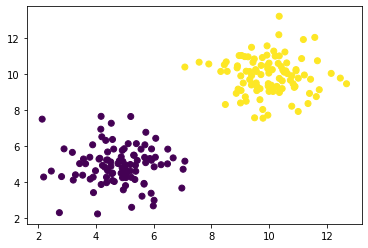

In [ ]:
plt.scatter(points[:, 0], points[:, 1], c= pred_labels)
plt.show()

In [ ]:
print(" ********************* \n * Résultats obtenus * \n *********************")
print('ARI = ', adjusted_rand_score(labels,pred_labels)) 
print('Nmi = ', normalized_mutual_info_score(labels,pred_labels)) 
print('Accuracy = ', bestAccuracy(labels,pred_labels)) 
print('Temps d\'execution = % secondes ' % exec_time) 

 ********************* 
 * Résultats obtenus * 
 *********************
ARI =  1.0
Nmi =  1.0
Accuracy =  1.0
Temps d'execution = 0.2722160816192627econdes 


N'avoir qu’une seule clé unique implique qu'il n'y a pas de
parallélisation.   
Supposons qu'on ait plusieurs classes et donc plusieurs centroides => Tous les centroides appartiennent à la même clé, ainsi les calculs ne seront pas parallélisés.  
Pour pallier à ça, nous pouvons créer des clés supplémentaires qui permettront de paralleliser les calculs. Ensuite, nous les agrégerons par clés naturelles d’origine du problème.

# **Partie E.** Implémentation d’une version streaming et distribuée de k-means

Implémenter avec Apache Beam l’algorithme décrit en partie B.

On peut utiliser le même principe que pour la partie D et conserver les batches dans la variable d’état.

In [ ]:
# début du temps d'exécution de l'algorithme 
start = time.time()

class MyClass(beam.DoFn):
  state1 = BagStateSpec(name='batches', coder=beam.coders.PickleCoder())
  state2 = BagStateSpec(name='partition', coder=beam.coders.PickleCoder())

  def process(self, element, X=beam.DoFn.StateParam(state1), P=beam.DoFn.StateParam(state2)):

    # Si la taille de X est T : enlever le plus vieux batch de X
    # sauvergarder les batches dans une variable temporaire
    # retirer le plus ancien batch de la variable temporaire
    # vider la variable d'état
    # ajouter à la variable d'état les batches contenus dans la variable temporaire
    if len(set(X.read())) == T:
      temp = list(X.read())
      temp.pop(0)
      X.clear()
      for i in temp :
        X.add(i)

    # Ajouter B⁰ à X
    key, B = element
    X.add(B)

    ## Partition de départ aléatoire
    if len(list(P.read())) == 0:
      l = [(k%2) for k in range(len(B))]
      P.add(l)

    # Initialiser les centroïdes C avec la partition P
    n_clusters = len(set(list(P.read())[0]))


    # Obtenir les centroïdes C et la partition P avec l’algorithme k-means pondéré
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.concatenate(list(X.read())), y=None, sample_weight=compute_weight_batch(list(X.read())))
    C = kmeans.cluster_centers_

    # vider la variable d'état pour avoir uniquement la dernière partition
    P.clear()
    P.add(kmeans.labels_)   
    
    # sortie : les centroides et la partition
    yield C, list(P.read())[0]


with beam.Pipeline() as pipeline:
  data = (
    pipeline
    | "Create" >> beam.Create(
      Batches
    )
  )

  (data
  | 'Add key' >> beam.Map(lambda x: (0,(x))) 
  | "Kmeans streaming et distribuée" >> beam.ParDo(MyClass())
  | "Print" >> beam.Map(lambda x : print(f'\nLes centres sont : {x[0]} \nLa partition est : {x[1]}'))
  )

# Fin du temps d'exécution de l'algorithme
end = time.time()

print(f'\nLe temps de exécution du programme est : {end-start}')


Les centres sont : [[ 0.5  0.5]
 [10.  10. ]] 
La partition est : [0 0 1]

Les centres sont : [[ 5.83333333 15.83333333]
 [ 1.57142857  5.14285714]] 
La partition est : [1 1 0 0 1]

Les centres sont : [[ 3.          5.97297297]
 [10.          4.23076923]] 
La partition est : [0 0 1 0 0 0 1]

Les centres sont : [[22.          5.        ]
 [10.05405405  7.81081081]] 
La partition est : [1 1 1 1 0 1]

Les centres sont : [[16.11111111  2.75      ]
 [ 1.07692308  5.92307692]] 
La partition est : [1 0 0 0 0 1]

Le temps de exécution du programme est : 0.33687901496887207


# **Conclusion générale**

Dans ce travail nous avons présenté plusieurs approches afin d'implémenter le K-Means. Chacune fait des choix différents pour répondre aux  contraintes, ainsi, nous ne pouvons affirmer laquelle est la meilleure.  
  

Cependant, nous avons pu effectuer un bilan de constatations:

*   Afin de limiter la consommation de mémoire, il est préférable de lire les données par ségment ou en parallélisant les calculs.  
Changer le type des données est également une bonne solution cependant il faut faire attention à garder l'integrité des données.
*   Les numpy array consomment moins de place en mémoire que les listes Python.   
*   Pour de paralléliser les calculs, il est important d'utiliser plusieurs clés. En effet, on constate que les versions des K-Means avec Apache Beam mettent plus de temps à s'executer que leur version plus classique.
*   La version séquentielle du K-Means est plus sensible à l'initialisation, contrairement à la version en streaming.
*   Bien que le K-Means séquentiel soit plus rapide que la version streaming, l'affectation aux clusters est plus robuste car on se base sur les résultats des anciens batch.



  
Pour conclure, ce travail nous a permis d'appliquer et d'approfondir les différentes notions vues en cours.